In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
# from dance_evaluation import *
import matplotlib.pyplot as plt
# from calculate_score import *
from collections import defaultdict

def load_pickle(filepath):
    with open(filepath, "rb") as f:
        json_data = pickle.load(f)
    return json_data

def save_to_pickle(filepath, data):
    # filepath = os.path.join(savepath, filename)
    with open(filepath, "wb") as f:
        pickle.dump(data, f)

#### New Update March 12

In [2]:
def calculate_metrics(ref, calculated, tol_type="abs", tolerance=5, mode = "one"):
    """
    Calculate Acc1, Acc2, Metric3, OE1, and OE2.
    Now, 'calculated' is a list of tuples, each containing n candidate BPM values.
    For each index, we select the candidate BPM that is closest to the ground truth.
    
    Args:
        ref (np.ndarray): Reference BPMs.
        calculated (list of tuple): Each tuple contains n candidate BPMs.
        tol_type (str): "abs" or "rel" tolerance type.
        tolerance (float): Tolerance value.
        
    Returns:
        dict: Dictionary with accuracy and error metrics.
    """
    # Determine the tolerance for comparison
    if tol_type == "rel":
        ref_tolerance = ref * (tolerance / 100)
    elif tol_type == "abs":
        ref_tolerance = tolerance

    if mode == "many":
        # For each index, choose the candidate BPM that minimizes the error from ref[i]
        chosen = np.array([
            min(cand, key=lambda bpm: abs(bpm - ref[i]))
            for i, cand in enumerate(calculated)
        ])
    
    elif mode == "one":
        chosen = calculated
    
    # Compute accuracy metrics using the chosen BPMs
    acc1_count = np.sum(np.abs(chosen - ref) <= ref_tolerance)
    acc2_count = np.sum(
        (np.abs(chosen - ref) <= ref_tolerance) |
        (np.abs(chosen - 2 * ref) <= ref_tolerance) |
        (np.abs(chosen - ref / 2) <= ref_tolerance)
    )
    
    scales = [1, 2, 0.5, 3, 1/3]
    acc3_count = np.sum(np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0))
    
    hits_idx = np.where(np.abs(chosen - ref) <= ref_tolerance)[0]
    hits_dbl_idx = np.where(np.abs(chosen - 2 * ref) <= ref_tolerance)[0]
    hits_hf_idx = np.where(np.abs(chosen - ref / 2) <= ref_tolerance)[0]
    
    bpm_hits_idx = chosen[hits_idx]
    bpm_hits_dbl_idx = chosen[hits_dbl_idx]
    bpm_hits_hf_idx = chosen[hits_hf_idx]
    
    base_tempo = ref[hits_idx]
    
    # Overestimated errors:
    oe1_count = np.sum(
        (chosen > ref) &
        ~np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0)
    )
    oe2_count = np.sum(
        (chosen > ref) &
        np.any([np.abs(chosen - ref * scale) <= ref_tolerance for scale in scales], axis=0)
    )
    
    total = len(ref)
    
    metrics = {
        "acc1": (acc1_count / total) * 100,
        "acc2": (acc2_count / total) * 100,
        "acc3": (acc3_count / total) * 100,
        "OE1": (oe1_count / total) * 100,
        "OE2": (oe2_count / total) * 100,
        "base_tempo": base_tempo,
        "hits_idx": hits_idx,
        "hits_dbl_idx": hits_dbl_idx,
        "hits_hf_idx": hits_hf_idx,
        "bpm_hits_idx": bpm_hits_idx,
        "bpm_hits_dbl_idx": bpm_hits_dbl_idx,
        "bpm_hits_hf_idx": bpm_hits_hf_idx
    }
    return metrics

In [40]:
bhf  = load_pickle("/itf-fi-ml/home/sagardu/aist_tempo_est/saved_result/tttempo_60_140/pos/bhf_zero_uni_W5_H2.5_60_140.pkl")

ref = bhf["music_tempo"].to_numpy()
res = calculate_metrics(ref, np.asarray(bhf["bpm_median"]), tol_type = "rel", tolerance = 6, mode = "one")
res

{'acc1': 61.44668158090977,
 'acc2': 61.67039522744221,
 'acc3': 61.67039522744221,
 'OE1': 29.157345264727812,
 'OE2': 30.723340790454884,
 'base_tempo': array([110, 135, 100, 110, 135, 100, 110, 130, 130, 130,  90,  90, 120,
        120, 130, 110,  80, 130,  90, 120, 120, 130, 130,  90,  80, 100,
        130, 120, 110, 120, 120, 130, 120,  90,  80, 130, 100, 100, 120,
        120, 120, 130, 100, 100, 130, 120, 130, 110, 100,  90,  90, 130,
        125, 115, 110, 120,  80,  80, 100, 100, 120, 120, 110, 100,  90,
        130, 120, 120,  90, 110,  90, 110, 110, 110, 130, 135, 110, 120,
        115,  90, 130,  80, 130, 120, 110, 130, 110,  90,  80, 120, 130,
        100, 130, 110, 130, 130, 130, 110, 120, 120, 100, 125, 110, 130,
        100, 130,  90,  80, 130, 110,  90, 110,  90, 130, 120, 130, 120,
        120, 125, 120,  80,  90, 130, 110, 120,  90, 100, 125, 110, 120,
         90, 120, 110, 130, 120, 120, 110,  90, 130, 120, 130, 120,  80,
        125, 120, 130, 120, 120, 120, 100, 

### Functions

In [12]:
def estimate_tempo_pair(a, b, mode, w_sec, h_sec):
    # Define the segment pairs to process
    segment_pairs = [
        ("both_hand_x", "both_foot_x"),                     # Example: bpm_pos ~35%, bpm_posvel ~55%
        ("both_hand_y", "both_foot_y"),                     # Example: bpm_pos ~70%, bpm_posvel ~81%
        ("both_hand_resultant", "both_foot_resultant"),     # Example: bpm_pos ~49%, bpm_posvel ~66%
        # ("bothhand_xy", "bothfoot_xy"),                     # Example: bpm_pos ~55%, bpm_posvel ~68%
    ]
    
    score_data = {}
    json_data = {}
    oPath = f"./saved_result/tempo_{a}_{b}/"
    # win_path = "./saved_result/window_cases/pos"
    # tem_path = f"./saved_result/tempo_cases/tempo_{a}_{b}/pos"
    bpm_dict = ["bpm_avg",  "bpm_mode", "bpm_median"]
    for bpm_mode in bpm_dict:
        score_data[bpm_mode] = {}
        json_data[bpm_mode] = {}
        for hnd, ft in segment_pairs:
            # Build file paths for position and velocity data
            read_file1 = oPath + f"pos/{hnd}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            read_file2 = oPath + f"pos/{ft}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            read_file3 = oPath + f"vel/{hnd}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            read_file4 = oPath + f"vel/{ft}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            
            # Load the dataframes
            df1 = pd.read_pickle(read_file1)
            df2 = pd.read_pickle(read_file2)
            df3 = pd.read_pickle(read_file3)
            df4 = pd.read_pickle(read_file4)
            
            # Build candidate BPM pairs (for positions) and quads (for positions and velocities)
            bpm_pos = []
            bpm_vel = []
            bpm_posvel = []
            for n in range(df1.shape[0]):
                bpm1 = df1.iloc[n][bpm_mode]   # hand (position)
                bpm2 = df2.iloc[n][bpm_mode]   # foot (position)
                bpm3 = df3.iloc[n][bpm_mode]   # hand (velocity)
                bpm4 = df4.iloc[n][bpm_mode]   # foot (velocity)
                
                bpm_pos.append((bpm1, bpm2))
                bpm_vel.append((bpm3, bpm4))
                bpm_posvel.append((bpm1, bpm2, bpm3, bpm4))
            
            # music_tempo from df1 
            ref = df1["music_tempo"].to_numpy()
            
            # Calculate metrics for the candidate
            metrics_pos = calculate_metrics(ref, bpm_pos, tol_type="rel", tolerance=6, mode = "many")
            metrics_vel = calculate_metrics(ref, bpm_vel, tol_type="rel", tolerance=6, mode = "many")
            metrics_posvel = calculate_metrics(ref, bpm_posvel, tol_type="rel", tolerance=6, mode = "many")

            pair_key = f"{hnd}_{ft}"
            
            score_data[bpm_mode][pair_key] = {"metrics_pos": metrics_pos, "metrics_vel": metrics_vel, "metrics_posvel": metrics_posvel}
                
            
            json_data[bpm_mode][pair_key] = {"bpm_pos": bpm_pos,
                                             "bpm_vel": bpm_vel,
                                            "bpm_posvel": bpm_posvel,
                                            "Acc1_bpm_pos": metrics_pos["acc1"],
                                            "Acc1_bpm_vel": metrics_vel["acc1"],
                                            "Acc1_bpm_posvel": metrics_posvel["acc1"],}
            
    
    #### Sace the score data to a pickle file
    # save_dir = f"./saved_result/tempo_{a}_{b}/score"
    # fname1 = f"score_multi_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
    # fpath1 = os.path.join(save_dir, fname1)
    # save_to_pickle(fpath1, score_data)
        
    return json_data

def estimate_tempo_one(a, b, mode, metric, w_sec, h_sec):

    segment_keys = [
                    "left_hand_x", "right_hand_x", "left_hand_y", "right_hand_y",   # singular
                    "left_foot_x", "right_foot_x", "left_foot_y", "right_foot_y",   # singular
                    
                    "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
                    "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                    
                    "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
                     "both_hand_resultant", "both_foot_resultant", # resultant of x and y onsets
                    ] # "bothhand_xy", "bothfoot_xy",
    score_data = {}
    json_data = {}
    bpm_dict = ["bpm_avg",  "bpm_mode", "bpm_median"]
    oPath = f"./saved_result/tempo_{a}_{b}/"
    for bpm_mode in bpm_dict:
        score_data[bpm_mode] = {}
        json_data[bpm_mode] = {}
        for idx, f_name in enumerate(segment_keys):
            f_path = oPath + f"{metric}/{f_name}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
            df_ax = pd.read_pickle(f_path)
            
            ref = df_ax["music_tempo"].to_numpy()
            metrics = calculate_metrics(ref, np.asarray(df_ax[bpm_mode]), tol_type = "rel", tolerance = 6, mode = "one")
            
            score_data[bpm_mode][f_name] = {f"metrics_{metric}": metrics}
                                    
            json_data[bpm_mode][f_name] = {"Acc1_bpm_one": metrics["acc1"]}
            # json_data[bpm_mode][f_name] = metrics     # new
            
    
    #### Save the score data to a pickle file
    # save_dir = f"./saved_result/tempo_{a}_{b}/score"
    # fname1 = f"score_one_{metric}_{mode}_W{w_sec}_H{h_sec}_{a}_{b}.pkl"
    # fpath1 = os.path.join(save_dir, fname1)
    # save_to_pickle(fpath1, score_data)
    
    return json_data

# a = 25; b= 60
# mode = "zero_uni"
# w_sec = 5; h_sec = w_sec/2

# jdata1 = estimate_tempo_pair(a, b, mode, w_sec, h_sec)      # overall acc1 per body segment
# jdata2 = estimate_tempo_one(a, b, mode, "pos", w_sec, h_sec)    # overall acc1 per body segment

# Plot Section

### Grouped Bar Plot: Tempo of independant body segment

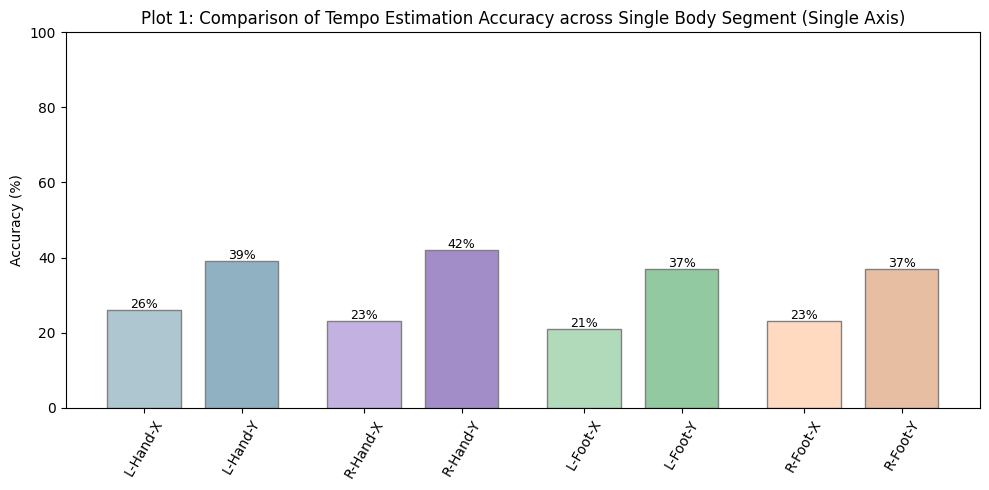

In [ ]:
# segment = [
#                 "left_hand_x", "left_hand_y", "right_hand_x", "right_hand_y",   # singular
#                 "left_foot_x", "left_foot_y", "right_foot_x", "right_foot_y",   # singular
                
#                 "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
#                 "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",   # singular | 18,20,17,17 %
                
#                 "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
#                 "bothhand_xy", "bothfoot_xy",
#                 "both_hand_resultant", "both_foot_resultant", 
#                 ] 

segments_1 = [
        "left_hand_x", "left_hand_y", "right_hand_x", "right_hand_y",   # singular
        "left_foot_x", "left_foot_y", "right_foot_x", "right_foot_y",   # singular
        ]


a = 60; b= 140
metric = "pos"
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)

accuracies1 = [round(t_data["bpm_median"][seg]['Acc1_bpm_one']) for seg in segments_1]

# Define labels
labels = [
    'L-Hand-X', 'L-Hand-Y', 'R-Hand-X', 'R-Hand-Y',
    'L-Foot-X', 'L-Foot-Y', 'R-Foot-X', 'R-Foot-Y',
]

bar_colors = [
    '#AEC6CF', '#8FB1C2',  # Left Hand (light & darker pastel blue)
    '#C3B1E1', '#A28DC8',  # Right Hand (light & darker pastel lavender)
    '#B0DAB9', '#92C9A0',  # Left Foot (light & darker pastel green)
    '#FFDAC1', '#E8BEA3',  # Right Foot (light & darker pastel peach)
    '#FFB7B2', '#E59893',  # Both Hands (light & darker pastel pink)
    '#FDFD96', '#E7E27D'   # Both Feet (light & darker pastel yellow)
]

# Parameter to control bar width
bar_width = 0.15

# Number of pairs
n_pairs = len(labels) // 2

# Positioning pairs
pair_spacing = 0.15  # space between pairs
inner_spacing = 0.05  # gap between bars within a pair

# Calculate positions for bars to group them in pairs
positions = []
for i in range(n_pairs):
    start_pos = i * (2 * bar_width + pair_spacing)
    positions.extend([start_pos, start_pos + bar_width + inner_spacing])

x = np.array(positions)

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(x, accuracies1, color=bar_colors, edgecolor='gray', width=bar_width)

# Customize plot
plt.xticks(x, labels, rotation=60)
plt.ylabel('Accuracy (%)')
plt.title('Plot 1: Comparison of Tempo Estimation Accuracy across Single Body Segment (Single Axis)')
plt.ylim(0, 100)

# Annotate bar heights
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{bar.get_height()}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

#### Bar plot: XY and resultant

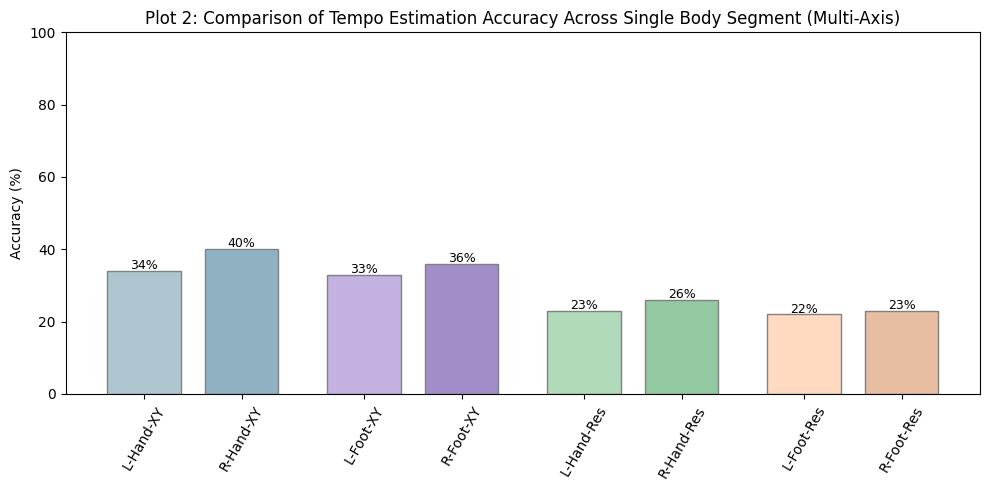

In [33]:
segments_2 = [
        "lefthand_xy", "righthand_xy", "leftfoot_xy", "rightfoot_xy",   # singular | 35, 40, 34, 36
        "left_hand_resultant", "right_hand_resultant", "left_foot_resultant", "right_foot_resultant",
        ]

# a = 60; b= 140
metric = "pos"
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)

accuracies = [round(t_data['bpm_median'][seg]['Acc1_bpm_one']) for seg in segments_2]

# Define labels
labels = [
    'L-Hand-XY', 'R-Hand-XY', 'L-Foot-XY', 'R-Foot-XY',
    'L-Hand-Res', 'R-Hand-Res', 'L-Foot-Res', 'R-Foot-Res',
]

bar_colors = [
    '#AEC6CF', '#8FB1C2',  # Left Hand (light & darker pastel blue)
    '#C3B1E1', '#A28DC8',  # Right Hand (light & darker pastel lavender)
    '#B0DAB9', '#92C9A0',  # Left Foot (light & darker pastel green)
    '#FFDAC1', '#E8BEA3',  # Right Foot (light & darker pastel peach)
    # '#FFB7B2', '#E59893',  # Both Hands (light & darker pastel pink)
    # '#FDFD96', '#E7E27D'   # Both Feet (light & darker pastel yellow)
]

# Parameter to control bar width
bar_width = 0.15

# Number of pairs
n_pairs = len(labels) // 2

# Positioning pairs
pair_spacing = 0.15  # space between pairs
inner_spacing = 0.05  # gap between bars within a pair

# Calculate positions for bars to group them in pairs
positions = []
for i in range(n_pairs):
    start_pos = i * (2 * bar_width + pair_spacing)
    positions.extend([start_pos, start_pos + bar_width + inner_spacing])

x = np.array(positions)

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(x, accuracies, color=bar_colors, edgecolor='gray', width=bar_width)

# Customize plot
plt.xticks(x, labels, rotation=60)
plt.ylabel('Accuracy (%)')
plt.title('Plot 2: Comparison of Tempo Estimation Accuracy Across Single Body Segment (Multi-Axis)')
plt.ylim(0, 100)

# Annotate bar heights
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{bar.get_height()}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

#### Bar Plot: Both Hand/Foot

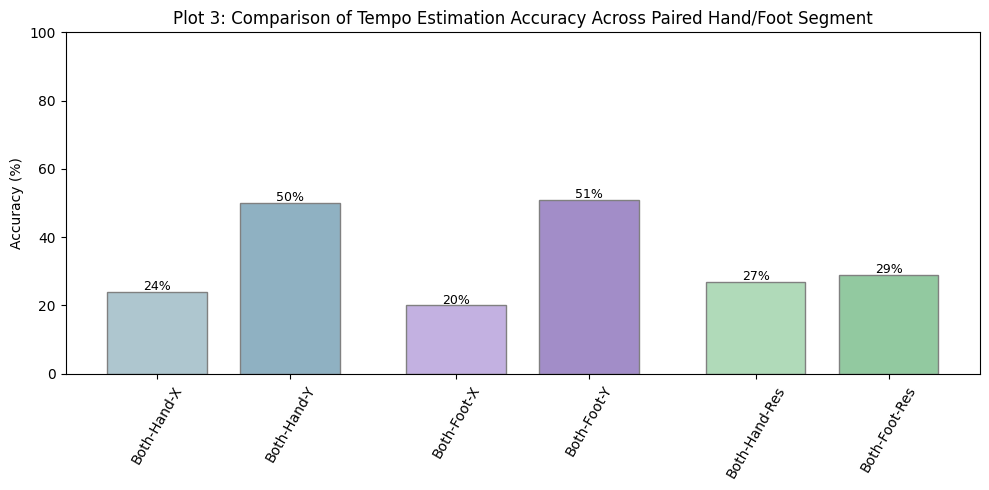

In [34]:
segments_3 = [
        "both_hand_x", "both_hand_y", "both_foot_x", "both_foot_y",
         "both_hand_resultant", "both_foot_resultant", 
        ]   # "bothhand_xy", "bothfoot_xy",

# a = 60; b= 140
metric = "pos"
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

t_data = estimate_tempo_one(a, b, mode, metric, w_sec, h_sec)

accuracies = [round(t_data['bpm_median'][seg]['Acc1_bpm_one']) for seg in segments_3]

# Define labels
labels = [
    'Both-Hand-X', 'Both-Hand-Y', 'Both-Foot-X', 'Both-Foot-Y',
     'Both-Hand-Res', 'Both-Foot-Res',
]   # 'Both-Hand-XY', 'Both-Foot-XY',

bar_colors = [
    '#AEC6CF', '#8FB1C2',  
    '#C3B1E1', '#A28DC8',  
    '#B0DAB9', '#92C9A0', 
    '#FFDAC1', '#E8BEA3',  
]

# Parameter to control bar width
bar_width = 0.15

# Number of pairs
n_pairs = len(labels) // 2

# Positioning pairs
pair_spacing = 0.15  # space between pairs
inner_spacing = 0.05  # gap between bars within a pair

# Calculate positions for bars to group them in pairs
positions = []
for i in range(n_pairs):
    start_pos = i * (2 * bar_width + pair_spacing)
    positions.extend([start_pos, start_pos + bar_width + inner_spacing])

x = np.array(positions)

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(x, accuracies, color=bar_colors, edgecolor='gray', width=bar_width)

# Customize plot
plt.xticks(x, labels, rotation=60)
plt.ylabel('Accuracy (%)')
plt.title('Plot 3: Comparison of Tempo Estimation Accuracy Across Paired Hand/Foot Segment')
plt.ylim(0, 100)

# Annotate bar heights
for bar in bars:
    plt.text( bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{bar.get_height()}%', ha='center', fontsize=9 )

plt.tight_layout()
plt.show()

### Bar Plot: Both Hand+Foot (Multi Score)

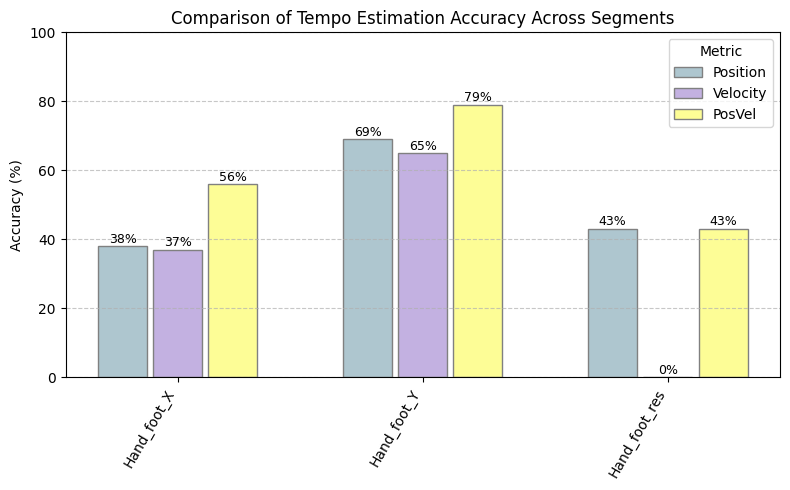

In [31]:
segments_3 = [
        'both_hand_x_both_foot_x', 'both_hand_y_both_foot_y', 
        'both_hand_resultant_both_foot_resultant'
        ]   # , 'bothhand_xy_bothfoot_xy'

# a = 25; b= 140
mode = "zero_uni"
w_sec = 5; h_sec = w_sec/2

t_data = estimate_tempo_pair(a, b, mode, w_sec, h_sec)
accuracies_pos = [round(t_data['bpm_median'][seg]['Acc1_bpm_pos']) for seg in segments_3]
accuracies_vel = [round(t_data['bpm_median'][seg]['Acc1_bpm_vel']) for seg in segments_3]
accuracies_posvel = [round(t_data['bpm_median'][seg]['Acc1_bpm_posvel']) for seg in segments_3]

labels = [
    'Hand_foot_X', 'Hand_foot_Y','Hand_foot_res', 
]   # , 'Hand_foot_XY' 

# Define colors for each metric as separate variables
pos_color    = '#AEC6CF'   # Color for Position-based accuracy
vel_color    = '#C3B1E1'   # Color for Velocity-based accuracy
posvel_color = '#FDFD96'   # Color for Combined PosVel accuracy

# Set up x-axis positions for groups
x = np.arange(len(labels))
bar_width = 0.2
inner_spacing = 0.05

# Calculate positions for each of the three bars per group
x_pos    = x - (bar_width + inner_spacing/2)
x_vel    = x
x_posvel = x + (bar_width + inner_spacing/2)

# Create the grouped bar plot
plt.figure(figsize=(8, 5))

bars_pos    = plt.bar(x_pos,    accuracies_pos,    width=bar_width, color=pos_color,    edgecolor='gray', label='Position')
bars_vel    = plt.bar(x_vel,    accuracies_vel,    width=bar_width, color=vel_color,    edgecolor='gray', label='Velocity')
bars_posvel = plt.bar(x_posvel, accuracies_posvel, width=bar_width, color=posvel_color, edgecolor='gray', label='PosVel')

plt.xticks(x, labels, rotation=60, ha='right')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Tempo Estimation Accuracy Across Segments')
plt.ylim(0, 100)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its value
for bar in bars_pos + bars_vel + bars_posvel:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f'{bar.get_height()}%',
        ha='center',
        fontsize=9
    )

plt.tight_layout()
plt.show()